In [1]:
!pip install reverse_geocoder
!pip install plotly_express

import pandas as pd
import numpy as np
import reverse_geocoder as rg
import plotly.graph_objects as go
import plotly_express as px


# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Output
#  df_ts_complete: df with values where time series is complete
#  df_estimate: df where all time series values are NaN but there is an estimate
#  df_ts_incomplete: df with values where at least one of time series values is NaN
# 
# Reads global powerplant data data from CSV, drops irrelevant columns, splits df (see output), 
# and re-indexes df with gppdf_idnr as index
def read_clean_and_split():  
    df = pd.read_csv("global_power_plant_database.csv")
    df_all = df.drop(['country_long', 'name', 'url', 'geolocation_source', 'wepp_id'], axis=1)
    
    df_ts = (df_all.dropna(how='all', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
                      .set_index('gppd_idnr'))
    df_ts_complete = df_ts.dropna(how='any', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
    df_estimate = (df_all.dropna(how='any', subset=['estimated_generation_gwh'])
                   .set_index('gppd_idnr'))
    df_ts_incomplete = df_ts[df_ts[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].isnull().any(axis=1)]
    return df_ts_complete, df_ts_incomplete, df_estimate    

In [3]:
df_ts_complete, *_ = read_clean_and_split()

In [4]:
df_US = df_ts_complete[df_ts_complete['country'] == 'USA']

In [5]:
# Adds a column with us_state to dataframe df
# The used library for reverse geocoding works with K-D trees.
# Might produce inaccurate results for border regions
def coordinate_to_state(df):
    
    coordinates = [*zip(df['latitude'], df['longitude'])]
    #Uncomment below to include (lat, long) tuple as new column in df
    #df.insert(4, 'coordinates', coordinates)

    geo_infos = rg.search(tuple(coordinates))

    locations = list()

    for item in geo_infos:
        locations.append(item['admin1'])

    df.insert(1, 'us_state', locations)   


In [6]:
# Fixes the obvious mistakes made by coordinate_to_state function (where us_state is not a US state)
# Based on looking up the locations manually
def fix_misclassification(df):
    #British Columbia
    df.at['USA0054249', 'us_state'] = 'Idaho'
    df.loc[df['us_state']=='British Columbia', 'us_state'] = 'Washington'
    
    #Quebec
    df.at['USA0056829', 'us_state'] = 'Maine'
    df.loc[df['us_state']=='Quebec', 'us_state'] = 'New York'
    
    #Baja California
    df.at['USA0000120', 'us_state'] = 'Arizona'
    df.loc[df['us_state']=='Baja California', 'us_state'] = 'California'
    
    #Ontario 
    df.at['USA0006369', 'us_state'] = 'Michigan'
    df.at['USA0010487', 'us_state'] = 'Minnesota'
    df.at['USA0002694', 'us_state'] = 'New York'
    
    #Chukotskiy Avtonomnyy Okrug
    df.loc[df['us_state']=='Chukotskiy Avtonomnyy Okrug', 'us_state'] = 'Alaska'
    
    #Tamaulipas
    df.loc[df['us_state']=='Tamaulipas', 'us_state'] = 'Texas'
    
    #Yukon
    df.loc[df['us_state']=='Yukon', 'us_state'] = 'Alaska'   

In [7]:
coordinate_to_state(df_US)
fix_misclassification(df_US)

Loading formatted geocoded file...


In [8]:
df_US['us_state'].value_counts()

California          912
New York            327
Texas               320
Minnesota           255
Iowa                213
North Carolina      207
Michigan            199
Pennsylvania        185
Illinois            183
New Jersey          182
Wisconsin           169
Massachusetts       160
Washington          132
Idaho               127
Ohio                126
Florida             125
Alaska              125
Colorado            124
Oregon              124
Kansas              117
Virginia            116
Georgia             113
Indiana             100
Missouri             95
Arizona              93
South Carolina       93
Nebraska             90
Maine                89
Oklahoma             77
Connecticut          75
Louisiana            75
Alabama              72
Utah                 67
New Mexico           65
Maryland             63
Nevada               63
New Hampshire        60
Wyoming              58
Vermont              57
Tennessee            53
Arkansas             52
Montana         

In [9]:
df_US

country    us_state  capacity_mw  latitude  longitude primary_fuel  \
gppd_idnr                                                                       
USA0059371     USA  New Jersey          1.9   40.2003   -74.5761        Solar   
USA0057310     USA  California          1.3   33.7943  -118.2414        Solar   
USA0057458     USA  New Jersey          3.8   40.5358   -74.3913        Solar   
USA0007770     USA    Illinois          4.2   41.9084   -89.0466          Gas   
USA0058187     USA  New Jersey          1.9   40.5161   -74.3400        Solar   
...            ...         ...          ...       ...        ...          ...   
USA0055392     USA    Illinois        596.7   42.4776   -87.8950          Gas   
USA0056871     USA    Illinois          7.0   42.4803   -87.8861        Waste   
USA0001368     USA     Indiana         18.0   38.2803   -85.7023          Gas   
USA0057648     USA    New York          3.4   42.8869   -76.9683         Wind   
USA0059281     USA        Utah          9.8   40.5606  -112.0478          Gas   

           other_fuel1 other_fuel2 other_fuel3  commissioning_year  \
gppd_idnr                                                            
USA0059371         NaN         NaN         NaN         2012.000000   
USA0057310         NaN         NaN         NaN         2011.000000   
USA0057458         NaN         NaN         NaN         2011.000000   
USA0007770         NaN         NaN         NaN         2000.000000   
USA0058187         NaN         NaN         NaN         2012.000000   
...                ...         ...         ...                 ...   
USA0055392         Oil         NaN         NaN         2002.333333   
USA0056871         NaN         NaN         NaN         2003.000000   
USA0001368         NaN         NaN         NaN         1969.000000   
USA0057648         NaN         NaN         NaN         2012.000000   
USA0059281         NaN         NaN         NaN         2013.775510   

                                        owner  \
gppd_idnr                                       
USA0059371                   SunRay Power LLC   
USA0057310                    Konoike Pacific   
USA0057458            Avidan Energy Solutions   
USA0007770       Rochelle Municipal Utilities   
USA0058187  180 Raritan Energy Solutions  LLC   
...                                       ...   
USA0055392                    Zion Energy LLC   
USA0056871            Energy Developments Inc   
USA0001368       Louisville Gas & Electric Co   
USA0057648                Zotos International   
USA0059281                       Bloom Energy   

                                            source  year_of_capacity_data  \
gppd_idnr                                                                   
USA0059371  U.S. Energy Information Administration                 2017.0   
USA0057310  U.S. Energy Information Administration                 2017.0   
USA0057458  U.S. Energy Information Administration                 2017.0   
USA0007770  U.S. Energy Information Administration                 2017.0   
USA0058187  U.S. Energy Information Administration                 2017.0   
...                                            ...                    ...   
USA0055392  U.S. Energy Information Administration                 2017.0   
USA0056871  U.S. Energy Information Administration                 2017.0   
USA0001368  U.S. Energy Information Administration                 2017.0   
USA0057648  U.S. Energy Information Administration                 2017.0   
USA0059281  U.S. Energy Information Administration                 2017.0   

            generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  \
gppd_idnr                                                                   
USA0059371              2.41461              2.35000             2.430000   
USA0057310              1.52800              2.14900             1.515000   
USA0057458              5.03600              4.52400             4.802000   
USA0007770           

In [10]:
df_US.primary_fuel.unique()

array(['Solar', 'Gas', 'Oil', 'Wind', 'Hydro', 'Coal', 'Biomass', 'Waste',
       'Cogeneration', 'Geothermal', 'Nuclear', 'Petcoke', 'Other',
       'Storage'], dtype=object)

In [11]:
colors = {'Solar':'yellow', 'Gas':'lightgreen', 'Oil':'olive', 'Wind':'cyan', 'Hydro':'blue', 'Coal':'black', 'Biomass':'green', 'Waste':'brown', 'Cogeneration':'bisque', 'Geothermal':'red', 'Nuclear':'orange', 'Petcoke':'teal', 'Other':'grey', 'Storage':'lime'}

In [12]:
fig = go.Figure(data=go.Scattergeo(
        lon = df_US['longitude'],
        lat = df_US['latitude'],
        text = df_US['primary_fuel'],
        mode = 'markers',
        marker_color = df_US['primary_fuel'].apply(lambda x: colors[x]),
        ))

fig.update_layout(
        title = 'Powerplants US',
        geo_scope='usa',
    )
fig.show()

In [13]:
#Green fuels = 1, non-green fuels = 0, other = 2
green_map = dict.fromkeys(['Hydro', 'Nuclear', 'Wind', 'Solar', 'Biomass', 'Waste', 'Geothermal', 'Cogeneration', 'Wave and Tidal', 'Storage'], 1)
green_map.update(dict.fromkeys(['Coal', 'Gas', 'Oil', 'Petcoke'], 0))
green_map.update(dict.fromkeys(['Other'], 2))

In [14]:
df_US['is_green'] = df_US['primary_fuel'].apply(lambda x: green_map[x])

In [15]:
#Returns a pivot table containing the ratio of green fuel generation / total fuel generation per year per state
def green_ratio_per_state(df_US):
    df_US = df_US[df_US['primary_fuel']!='Other']
    df_US['green_gwh_2013'] = df_US['generation_gwh_2013']*df_US['is_green']
    df_US['green_gwh_2014'] = df_US['generation_gwh_2014']*df_US['is_green']
    df_US['green_gwh_2015'] = df_US['generation_gwh_2015']*df_US['is_green']
    df_US['green_gwh_2016'] = df_US['generation_gwh_2016']*df_US['is_green']
    df_US['green_gwh_2017'] = df_US['generation_gwh_2017']*df_US['is_green']
    
    values = ['generation_gwh_2013', 'green_gwh_2013', 'generation_gwh_2014', 'green_gwh_2014', 'generation_gwh_2015', 'green_gwh_2015', 'generation_gwh_2016', 'green_gwh_2016','generation_gwh_2017', 'green_gwh_2017']

    pt = pd.pivot_table(df_US,index=["us_state"], values=values, aggfunc=np.sum)
    
    pt['2013'] = pt['green_gwh_2013']/pt['generation_gwh_2013']
    pt['2014'] = pt['green_gwh_2014']/pt['generation_gwh_2014']
    pt['2015'] = pt['green_gwh_2015']/pt['generation_gwh_2015']
    pt['2016'] = pt['green_gwh_2016']/pt['generation_gwh_2016']
    pt['2017'] = pt['green_gwh_2017']/pt['generation_gwh_2017']
    
    pt = pt.drop('Washington, D.C.') #has only one powerplant

    return pt, pt[['2013','2014', '2015','2016','2017']]

In [16]:
_, pt = green_ratio_per_state(df_US)
pt

2013      2014      2015      2016      2017
us_state                                                        
Alabama         0.449954  0.453324  0.437674  0.454043  0.399506
Alaska          0.254428  0.312361  0.334680  0.359345  0.296758
Arizona         0.349336  0.405376  0.406509  0.418049  0.408148
Arkansas        0.257145  0.286701  0.339753  0.300151  0.271968
California      0.401862  0.385123  0.378653  0.481645  0.525750
Colorado        0.102204  0.114266  0.105093  0.119395  0.113537
Connecticut     0.712929  0.695986  0.514323  0.498962  0.527072
Delaware        0.902666  0.922609  0.808972  0.805701  0.840813
Florida         0.237783  0.272312  0.286022  0.280565  0.185365
Georgia         0.391162  0.288953  0.275682  0.209712  0.203409
Hawaii          0.132218  0.178928  0.201190  0.206628  0.141007
Idaho           0.853574  0.901898  0.854134  0.883634  0.832281
Illinois        0.455351  0.520077  0.521526  0.577963  0.481541
Indiana         0.044734  0.044367  0.052309  0.056807  0.052157
Iowa            0.603725  0.610351  0.613959  0.653854  0.628197
Kansas          0.338394  0.393440  0.423927  0.412158  0.471059
Kentucky        0.048079  0.043575  0.047159  0.046779  0.057315
Louisiana       0.223250  0.222867  0.184925  0.204630  0.208600
Maine           0.636248  0.569982  0.597822  0.576495  0.675293
Maryland        0.441730  0.435927  0.437337  0.499053  0.563523
Massachusetts   0.275093  0.344698  0.298087  0.301347  0.265558
Michigan        0.390174  0.417928  0.344179  0.371467  0.359375
Minnesota       0.514938  0.532719  0.526973  0.537121  0.461962
Mississippi     0.239324  0.216332  0.220913  0.133675  0.162057
Missouri        0.206668  0.218169  0.251899  0.237525  0.209902
Montana         0.437929  0.461896  0.416310  0.450550  0.474020
Nebraska        0.160291  0.172709  0.183469  0.199959  0.144152
Nevada          0.237811  0.275542  0.236976  0.240120  0.252873
New Hampshire   0.745139  0.737137  0.688621  0.786670  0.813803
New Jersey      0.179412  0.153133  0.153642  0.138083  0.200937
New Mexico      0.117984  0.120748  0.070202  0.107846  0.086871
New York        0.584820  0.587056  0.596027  0.609596  0.598259
North Carolina  0.455068  0.410809  0.427474  0.442881  0.406191
North Dakota    0.277802  0.322700  0.281603  0.286441  0.229541
Ohio            0.246884  0.239947  0.232070  0.219851  0.223717
Oklahoma        0.212902  0.254263  0.209691  0.223365  0.214056
Oregon          0.625950  0.629119  0.627738  0.631569  0.653120
Pennsylvania    0.415493  0.424073  0.444324  0.521209  0.470782
Rhode Island    0.008488  0.034490  0.033129  0.032842  0.029009
South Carolina  0.696346  0.672060  0.701019  0.801988  0.685430
South Dakota    0.936289  0.950958  0.914940  0.893021  0.929276
Tennessee       0.548101  0.484715  0.477558  0.477627  0.543095
Texas           0.191797  0.200827  0.189908  0.201821  0.190900
Utah            0.034346  0.048422  0.046302  0.055365  0.071426
Vermont         0.961276  0.969085  0.968865  0.969672  0.973545
Virginia        0.529101  0.524812  0.496896  0.550363  0.482137
Washington      0.923726  0.936390  0.865985  0.894226  0.875378
West Virginia   0.039029  0.032938  0.041282  0.048712  0.036933
Wisconsin       0.332035  0.388132  0.290647  0.430685  0.230767
Wyoming         0.113368  0.121432  0.108451  0.130166  0.126844

In [17]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [18]:
# plotting libraries expect stat-code as input
states = list(pt.index)
pt['code']=list(map(lambda x: us_state_abbrev[x], states))
pt

2013      2014      2015      2016      2017 code
us_state                                                             
Alabama         0.449954  0.453324  0.437674  0.454043  0.399506   AL
Alaska          0.254428  0.312361  0.334680  0.359345  0.296758   AK
Arizona         0.349336  0.405376  0.406509  0.418049  0.408148   AZ
Arkansas        0.257145  0.286701  0.339753  0.300151  0.271968   AR
California      0.401862  0.385123  0.378653  0.481645  0.525750   CA
Colorado        0.102204  0.114266  0.105093  0.119395  0.113537   CO
Connecticut     0.712929  0.695986  0.514323  0.498962  0.527072   CT
Delaware        0.902666  0.922609  0.808972  0.805701  0.840813   DE
Florida         0.237783  0.272312  0.286022  0.280565  0.185365   FL
Georgia         0.391162  0.288953  0.275682  0.209712  0.203409   GA
Hawaii          0.132218  0.178928  0.201190  0.206628  0.141007   HI
Idaho           0.853574  0.901898  0.854134  0.883634  0.832281   ID
Illinois        0.455351  0.520077  0.521526  0.577963  0.481541   IL
Indiana         0.044734  0.044367  0.052309  0.056807  0.052157   IN
Iowa            0.603725  0.610351  0.613959  0.653854  0.628197   IA
Kansas          0.338394  0.393440  0.423927  0.412158  0.471059   KS
Kentucky        0.048079  0.043575  0.047159  0.046779  0.057315   KY
Louisiana       0.223250  0.222867  0.184925  0.204630  0.208600   LA
Maine           0.636248  0.569982  0.597822  0.576495  0.675293   ME
Maryland        0.441730  0.435927  0.437337  0.499053  0.563523   MD
Massachusetts   0.275093  0.344698  0.298087  0.301347  0.265558   MA
Michigan        0.390174  0.417928  0.344179  0.371467  0.359375   MI
Minnesota       0.514938  0.532719  0.526973  0.537121  0.461962   MN
Mississippi     0.239324  0.216332  0.220913  0.133675  0.162057   MS
Missouri        0.206668  0.218169  0.251899  0.237525  0.209902   MO
Montana         0.437929  0.461896  0.416310  0.450550  0.474020   MT
Nebraska        0.160291  0.172709  0.183469  0.199959  0.144152   NE
Nevada          0.237811  0.275542  0.236976  0.240120  0.252873   NV
New Hampshire   0.745139  0.737137  0.688621  0.786670  0.813803   NH
New Jersey      0.179412  0.153133  0.153642  0.138083  0.200937   NJ
New Mexico      0.117984  0.120748  0.070202  0.107846  0.086871   NM
New York        0.584820  0.587056  0.596027  0.609596  0.598259   NY
North Carolina  0.455068  0.410809  0.427474  0.442881  0.406191   NC
North Dakota    0.277802  0.322700  0.281603  0.286441  0.229541   ND
Ohio            0.246884  0.239947  0.232070  0.219851  0.223717   OH
Oklahoma        0.212902  0.254263  0.209691  0.223365  0.214056   OK
Oregon          0.625950  0.629119  0.627738  0.631569  0.653120   OR
Pennsylvania    0.415493  0.424073  0.444324  0.521209  0.470782   PA
Rhode Island    0.008488  0.034490  0.033129  0.032842  0.029009   RI
South Carolina  0.696346  0.672060  0.701019  0.801988  0.685430   SC
South Dakota    0.936289  0.950958  0.914940  0.893021  0.929276   SD
Tennessee       0.548101  0.484715  0.477558  0.477627  0.543095   TN
Texas           0.191797  0.200827  0.189908  0.201821  0.190900   TX
Utah            0.034346  0.048422  0.046302  0.055365  0.071426   UT
Vermont         0.961276  0.969085  0.968865  0.969672  0.973545   VT
Virginia        0.529101  0.524812  0.496896  0.550363  0.482137   VA
Washington      0.923726  0.936390  0.865985  0.894226  0.875378   WA
West Virginia   0.039029  0.032938  0.041282  0.048712  0.036933   WV
Wisconsin       0.332035  0.388132  0.290647  0.430685  0.230767   WI
Wyoming         0.113368  0.121432  0.108451  0.130166  0.126844   WY

In [20]:
#px.chloropleth expects data in a certain shape, so we need to reshape

pt['us_state'] = pt.index

pt2 = pt.melt(id_vars=['us_state', 'code'], 
        var_name='year', 
        value_name='Green fuels (%)')

pt2

us_state code  year  Green fuels (%)
0          Alabama   AL  2013         0.449954
1           Alaska   AK  2013         0.254428
2          Arizona   AZ  2013         0.349336
3         Arkansas   AR  2013         0.257145
4       California   CA  2013         0.401862
..             ...  ...   ...              ...
245       Virginia   VA  2017         0.482137
246     Washington   WA  2017         0.875378
247  West Virginia   WV  2017         0.036933
248      Wisconsin   WI  2017         0.230767
249        Wyoming   WY  2017         0.126844

[250 rows x 4 columns]

In [21]:
fig = px.choropleth(pt2, 
              locations='code', 
              locationmode = 'USA-states', 
              scope = 'usa', 
              color="Green fuels (%)", 
              hover_name="Green fuels (%)", 
              hover_data=['us_state'],
              animation_frame="year",              
              color_continuous_scale=["white", "green"])

fig.update_layout(
    title_text = 'U.S. Green over non-Green fuels by State',
)
fig.show()

## Statistical Analyses

### Correlation Analysis

In [27]:
df_US.drop(['year_of_capacity_data', 'estimated_generation_gwh'], axis=1, inplace=True)
df_US

country    us_state  capacity_mw  latitude  longitude primary_fuel  \
gppd_idnr                                                                       
USA0059371     USA  New Jersey          1.9   40.2003   -74.5761        Solar   
USA0057310     USA  California          1.3   33.7943  -118.2414        Solar   
USA0057458     USA  New Jersey          3.8   40.5358   -74.3913        Solar   
USA0007770     USA    Illinois          4.2   41.9084   -89.0466          Gas   
USA0058187     USA  New Jersey          1.9   40.5161   -74.3400        Solar   
...            ...         ...          ...       ...        ...          ...   
USA0055392     USA    Illinois        596.7   42.4776   -87.8950          Gas   
USA0056871     USA    Illinois          7.0   42.4803   -87.8861        Waste   
USA0001368     USA     Indiana         18.0   38.2803   -85.7023          Gas   
USA0057648     USA    New York          3.4   42.8869   -76.9683         Wind   
USA0059281     USA        Utah          9.8   40.5606  -112.0478          Gas   

           other_fuel1 other_fuel2 other_fuel3  commissioning_year  \
gppd_idnr                                                            
USA0059371         NaN         NaN         NaN         2012.000000   
USA0057310         NaN         NaN         NaN         2011.000000   
USA0057458         NaN         NaN         NaN         2011.000000   
USA0007770         NaN         NaN         NaN         2000.000000   
USA0058187         NaN         NaN         NaN         2012.000000   
...                ...         ...         ...                 ...   
USA0055392         Oil         NaN         NaN         2002.333333   
USA0056871         NaN         NaN         NaN         2003.000000   
USA0001368         NaN         NaN         NaN         1969.000000   
USA0057648         NaN         NaN         NaN         2012.000000   
USA0059281         NaN         NaN         NaN         2013.775510   

                                        owner  \
gppd_idnr                                       
USA0059371                   SunRay Power LLC   
USA0057310                    Konoike Pacific   
USA0057458            Avidan Energy Solutions   
USA0007770       Rochelle Municipal Utilities   
USA0058187  180 Raritan Energy Solutions  LLC   
...                                       ...   
USA0055392                    Zion Energy LLC   
USA0056871            Energy Developments Inc   
USA0001368       Louisville Gas & Electric Co   
USA0057648                Zotos International   
USA0059281                       Bloom Energy   

                                            source  generation_gwh_2013  \
gppd_idnr                                                                 
USA0059371  U.S. Energy Information Administration              2.41461   
USA0057310  U.S. Energy Information Administration              1.52800   
USA0057458  U.S. Energy Information Administration              5.03600   
USA0007770  U.S. Energy Information Administration              0.21500   
USA0058187  U.S. Energy Information Administration              2.74100   
...                                            ...                  ...   
USA0055392  U.S. Energy Information Administration              0.00000   
USA0056871  U.S. Energy Information Administration             43.59200   
USA0001368  U.S. Energy Information Administration              0.20300   
USA0057648  U.S. Energy Information Administration              3.67100   
USA0059281  U.S. Energy Information Administration             12.96800   

            generation_gwh_2014  generation_gwh_2015  generation_gwh_2016  \
gppd_idnr                                                                   
USA0059371              2.35000             2.430000             2.492000   
USA0057310              2.14900             1.515000             1.592000   
USA0057458              4.52400             4.802000             5.051000   
USA0007770              0.17800             0.2

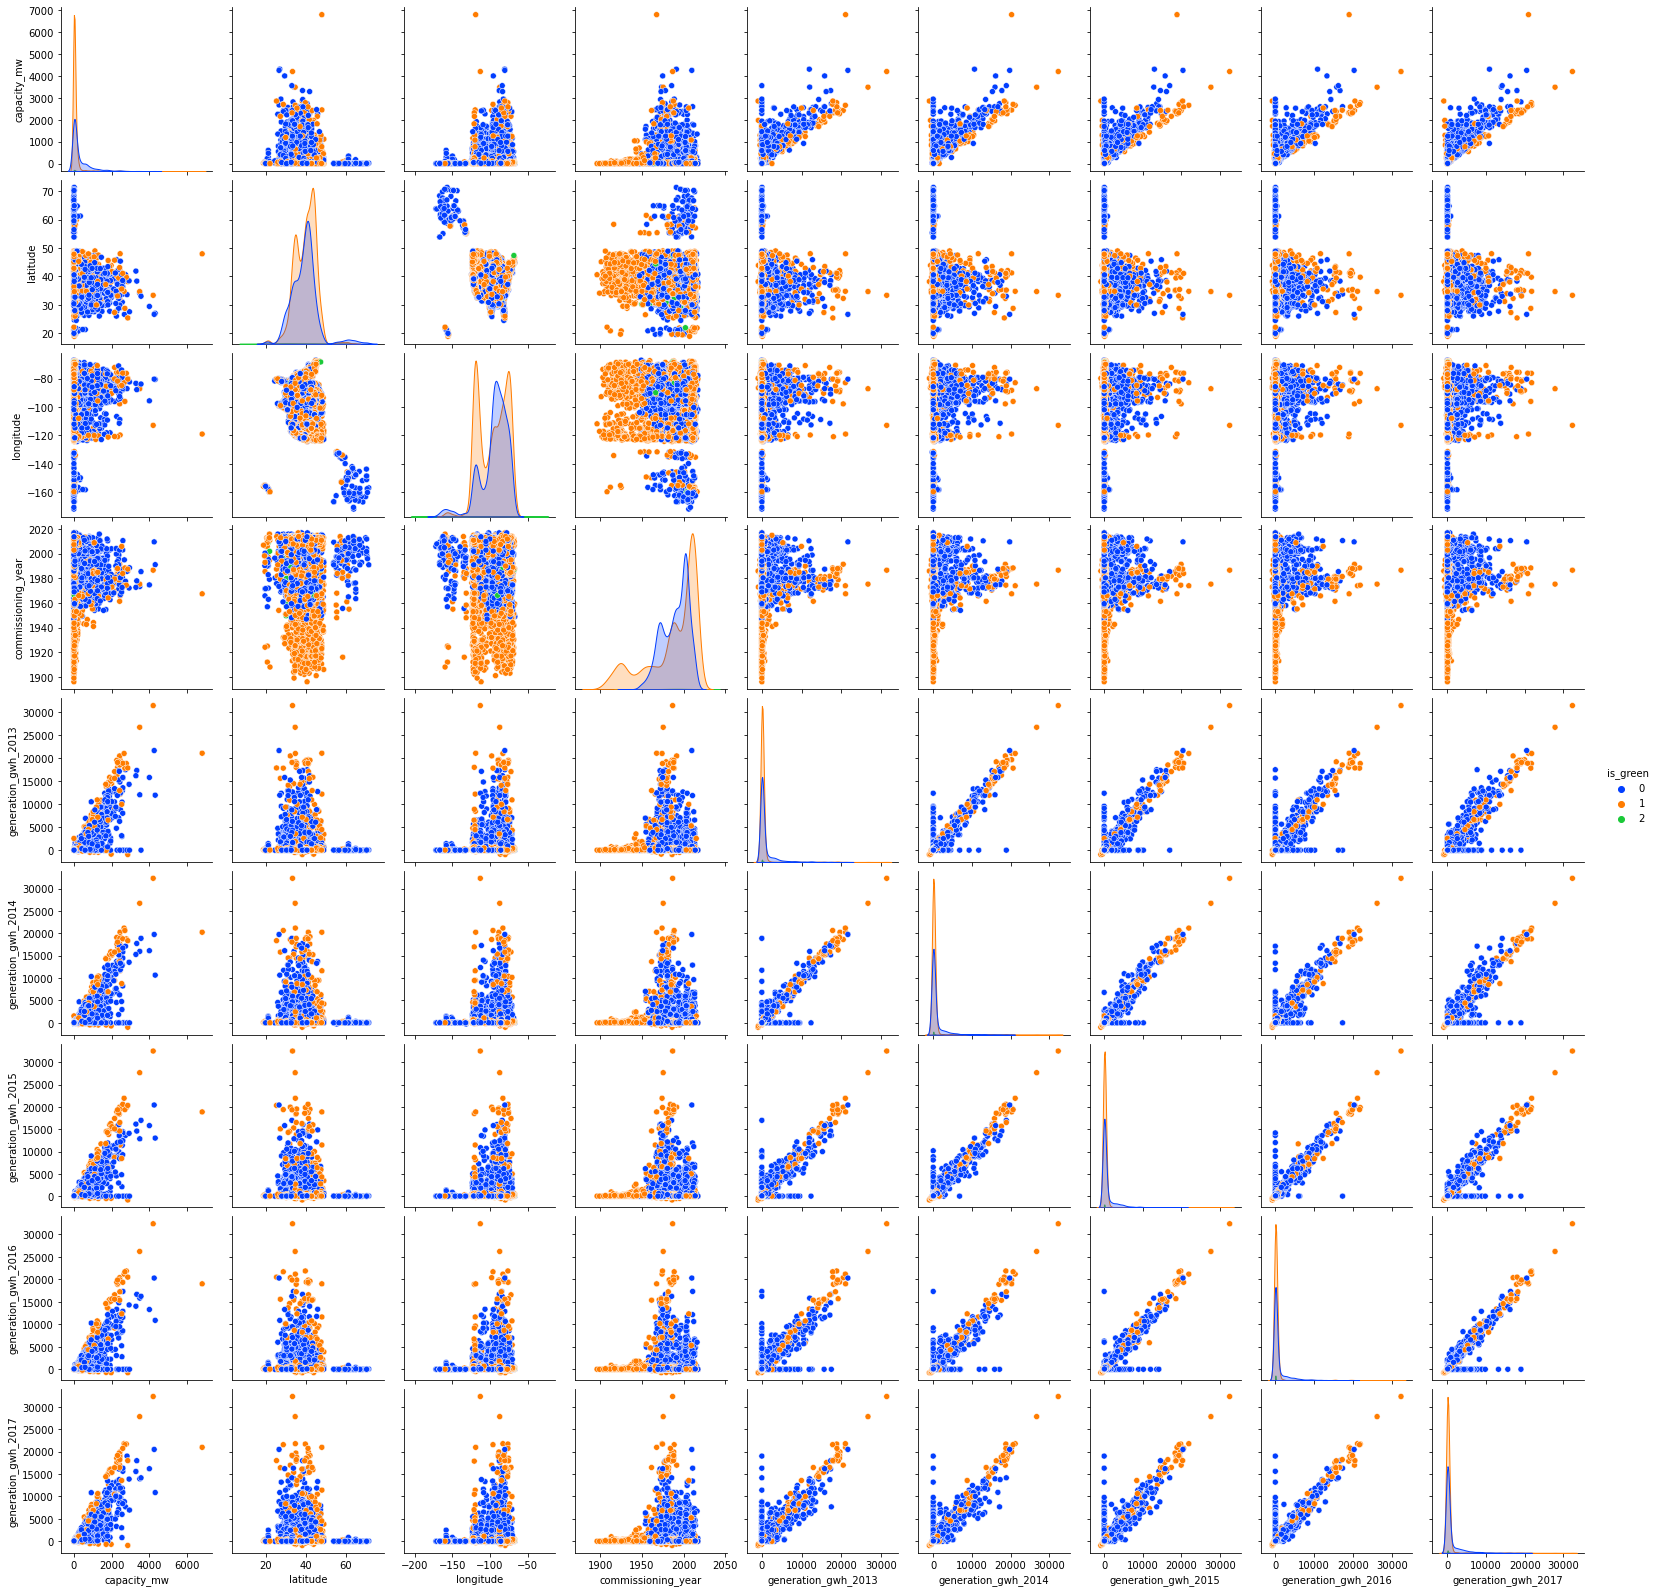

In [31]:
# Constructs a pairplot, similar to scatter matrix, to visualize the correlation with powerplants color coded by green, not green or other
seaborn.pairplot(df_US, hue = 'is_green', palette = 'bright')

<AxesSubplot:>

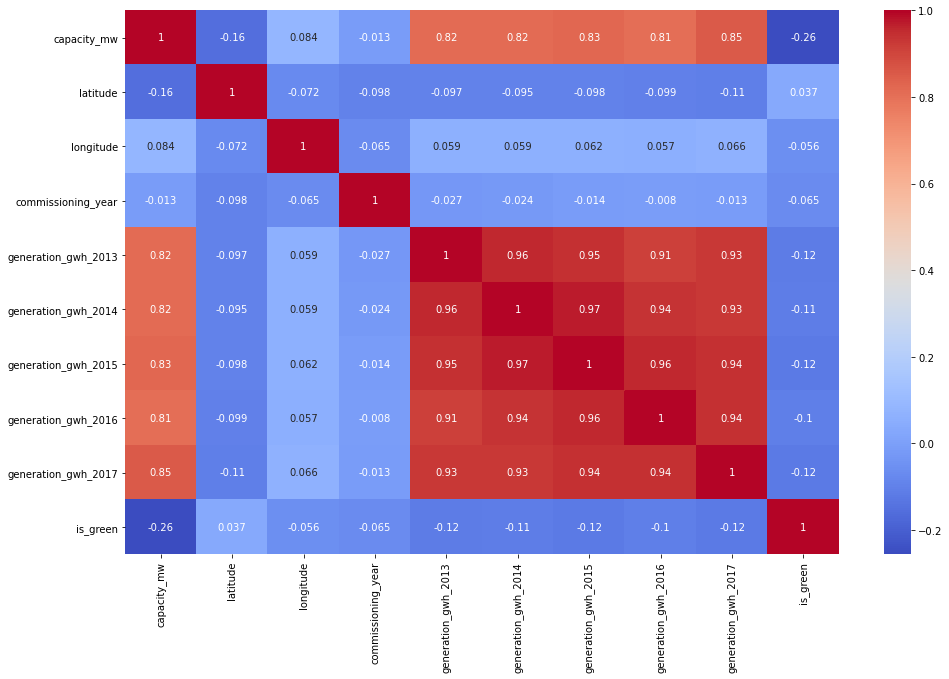

In [28]:
#Constructs a heatmap for correlation coefficient using seaborn
import seaborn
import matplotlib.pyplot as plt
plt.figure(figsize = (16,10))
seaborn.heatmap(df_US.corr(), annot = True, cmap = "coolwarm")

**Interpretation:**

In the US, from the visualizations above, production capacity_mw and actual energy generation for years 2013-2017 seem to be highly correlated. And moreover, the energy generation year by year seem to be highly correlated with each other. So, in the next section we shall build a regression model for the year 2017 generation based on these correlated variables. 

### Regression Models

#### Simple linear models

In [32]:
# Builds a simple linear model for energy generation 2017 based on production capacity_mw
import statsmodels.formula.api as sm

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ capacity_mw", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     generation_gwh_2017   R-squared:                       0.728
Model:                             OLS   Adj. R-squared:                  0.728
Method:                  Least Squares   F-statistic:                 1.675e+04
Date:                 Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                         18:42:07   Log-Likelihood:                -52534.
No. Observations:                 6244   AIC:                         1.051e+05
Df Residuals:                     6242   BIC:                         1.051e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -140.0534     14.965     -9.359      0.000    -169.390    -110.717
capacity_mw     4.2320      0.033    129.415      0.000       4.168       4.296
==============================================================================
Omnibus:                     3044.905   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           374513.794
Skew:                           1.336   Prob(JB):                         0.00
Kurtosis:                      40.847   Cond. No.                         496.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2013

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2013", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     generation_gwh_2017   R-squared:                       0.864
Model:                             OLS   Adj. R-squared:                  0.864
Method:                  Least Squares   F-statistic:                 3.971e+04
Date:                 Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                         18:42:57   Log-Likelihood:                -50372.
No. Observations:                 6244   AIC:                         1.007e+05
Df Residuals:                     6242   BIC:                         1.008e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              67.9318     10.134      6.704      0.000      48.066      87.797
generation_gwh_2013     0.9358      0.005    199.267      0.000       0.927       0.945
==============================================================================
Omnibus:                     8654.936   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5586132.224
Skew:                           7.681   Prob(JB):                         0.00
Kurtosis:                     148.724   Cond. No.                     2.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2014

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2014", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     generation_gwh_2017   R-squared:                       0.861
Model:                             OLS   Adj. R-squared:                  0.861
Method:                  Least Squares   F-statistic:                 3.875e+04
Date:                 Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                         18:43:35   Log-Likelihood:                -50438.
No. Observations:                 6244   AIC:                         1.009e+05
Df Residuals:                     6242   BIC:                         1.009e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              75.8163     10.232      7.410      0.000      55.758      95.874
generation_gwh_2014     0.9341      0.005    196.843      0.000       0.925       0.943
==============================================================================
Omnibus:                     8520.611   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4819001.634
Skew:                           7.494   Prob(JB):                         0.00
Kurtosis:                     138.271   Cond. No.                     2.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2015

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2015", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     generation_gwh_2017   R-squared:                       0.892
Model:                             OLS   Adj. R-squared:                  0.892
Method:                  Least Squares   F-statistic:                 5.131e+04
Date:                 Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                         18:44:41   Log-Likelihood:                -49669.
No. Observations:                 6244   AIC:                         9.934e+04
Df Residuals:                     6242   BIC:                         9.936e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              50.7726      9.065      5.601      0.000      33.002      68.543
generation_gwh_2015     0.9644      0.004    226.521      0.000       0.956       0.973
==============================================================================
Omnibus:                     9921.587   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11023041.618
Skew:                           9.981   Prob(JB):                         0.00
Kurtosis:                     207.868   Cond. No.                     2.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2016

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2016", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     generation_gwh_2017   R-squared:                       0.890
Model:                             OLS   Adj. R-squared:                  0.890
Method:                  Least Squares   F-statistic:                 5.074e+04
Date:                 Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                         18:45:22   Log-Likelihood:                -49701.
No. Observations:                 6244   AIC:                         9.941e+04
Df Residuals:                     6242   BIC:                         9.942e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              64.8904      9.094      7.135      0.000      47.063      82.718
generation_gwh_2016     0.9782      0.004    225.250      0.000       0.970       0.987
==============================================================================
Omnibus:                    10430.830   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10634342.005
Skew:                          11.189   Prob(JB):                         0.00
Kurtosis:                     203.934   Cond. No.                     2.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation:**

In building the simple linear models for the US, we found out that for estimating the 2017 energy generation, the data from the 2015 had the highest R-squared coefficient among everyone at 0.892. However, for other years were also quite close, with 2016 being 0.890, 2013 being 0.864 and 2014 being 0.861. Contrary to our correlation matrix, the data for capacity_mw was not a particularly strong predictor for energy generation in 2017 with a R-squared coefficient of 0.728. So, to build a even stronger model, we try to build a multilinear regression model based on energy generation from 2013-2016. 

### Multilinear Regression model

In [40]:
# Builds a multilinear model for energy generation 2017 based on energy generated in years 2013-2016

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ capacity_mw + generation_gwh_2013 + generation_gwh_2014 + generation_gwh_2015 + generation_gwh_2016", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     generation_gwh_2017   R-squared:                       0.932
Model:                             OLS   Adj. R-squared:                  0.932
Method:                  Least Squares   F-statistic:                 1.700e+04
Date:                 Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                         19:03:07   Log-Likelihood:                -48228.
No. Observations:                 6244   AIC:                         9.647e+04
Df Residuals:                     6238   BIC:                         9.651e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -31.9230      7.557     -4.224      0.000     -46.738     -17.108
capacity_mw             0.9107      0.030     30.546      0.000       0.852       0.969
generation_gwh_2013     0.3207      0.012     26.427      0.000       0.297       0.345
generation_gwh_2014    -0.1399      0.017     -8.346      0.000      -0.173      -0.107
generation_gwh_2015     0.2125      0.018     11.738      0.000       0.177       0.248
generation_gwh_2016     0.4518      0.012     36.742      0.000       0.428       0.476
==============================================================================
Omnibus:                     8465.660   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8208175.456
Skew:                           7.170   Prob(JB):                         0.00
Kurtosis:                     180.042   Cond. No.                     4.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation:**

Based on our simple linear models above, we built a multilinear regression model for predicting the energy generation in 2017 based on data from 2013-2016 and the production capacity_mw. And we have a very strong model with a R-squared coefficient of 0.932 meaning that this model will be useful for prediction. Next we use the cross validation method to find out the robustness of this model.

### Cross Validation

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Applying the cross validation method

X = df_US[['capacity_mw', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016']]
y = df_US["generation_gwh_2017"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) # 67% of data in training set, 33% in the test set
lr = LinearRegression()
lr.fit(X = X_train, y = y_train)
print ("Training accuracy: ",lr.score(X_train, y_train))
print ("Test accuracy: ", lr.score(X_test, y_test))

Training accuracy:  0.9348484994178727
Test accuracy:  0.9174855254588412


**Interpretation:**

Using cross validation, we see that our model can correctly predict 93.5% of the training set and 91.7% of the test dataset. This means that our multilinear regression model will correctly predict the dependent value in 91.7% of the points that were not used to train the model, which is quite good.

### Logistic Regression model

In [70]:
import statsmodels.api as sm

#Green fuels = 1, non-green fuels = 0, other = 0
green_map = dict.fromkeys(['Hydro', 'Nuclear', 'Wind', 'Solar', 'Biomass', 'Waste', 'Geothermal', 'Cogeneration', 'Wave and Tidal', 'Storage'], 1)
green_map.update(dict.fromkeys(['Coal', 'Gas', 'Oil', 'Petcoke'], 0))
green_map.update(dict.fromkeys(['Other'], 0))

df_US['is_green'] = df_US['primary_fuel'].apply(lambda x: green_map[x])

#Build a logistic regression model based on the following variables to predict whether a poweplant is green or not

x_train = df_US[['capacity_mw', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']] 
y_train = df_US[['is_green']] 
logit_reg = sm.Logit(y_train, x_train).fit()
print(logit_reg.summary()) 

Optimization terminated successfully.
         Current function value: 0.652294
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               is_green   No. Observations:                 6244
Model:                          Logit   Df Residuals:                     6238
Method:                           MLE   Df Model:                            5
Date:                Mon, 22 Mar 2021   Pseudo R-squ.:                 0.04639
Time:                        20:05:07   Log-Likelihood:                -4072.9
converged:                       True   LL-Null:                       -4271.1
Covariance Type:            nonrobust   LLR p-value:                 1.874e-83
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
capacity_mw            -0.0037      0.000    -16.098      0.000      -0.004      -0.003
ge

**Interpretation:**

We tried to build a logistic regression model to predict whether a given powerplant is green or not based on the variables capacity_mw and energy generated from 2013-2017. However, the model is not very good at predicting it. 


### Hypothesis testing - has there been an increase in energy output between years (2013-2017) in the US?

In [42]:
df_US1 =df_US[["generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
df_US1.describe()

generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  \
count          6244.000000          6244.000000          6244.000000   
mean            576.499422           569.110502           577.240897   
std            2079.502035          2079.797372          2049.724535   
min            -947.600000          -989.619000          -864.428000   
25%               1.738500             2.155750             2.022500   
50%              21.357500            20.787000            20.599000   
75%             185.301499           177.918500           182.001000   
max           31431.080000         32320.917000         32525.595000   

       generation_gwh_2016  generation_gwh_2017  
count          6244.000000          6244.000000  
mean            554.631885           607.436558  
std            2019.451285          2093.437107  
min            -768.620000          -934.944000  
25%               1.905500             3.724250  
50%              19.981795            29.531500  
75%             178.971750           223.098250  
max           32377.477000         32340.138000

#### Boxplot

Text(0, 0.5, 'Energy output (in GWh)')

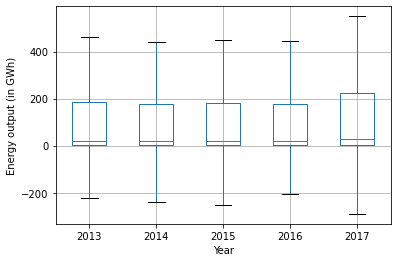

In [43]:
# Draws a boxplot for energy generation between 2013 -2017
df_US1.boxplot(showfliers=False)
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")

**Interpretation:**

There does not really seem to be an increase in output between 2013 and 2014 since the mean has decreased. For 2014-15, there seems to be an increase in average generation, which we shall investigate. And similarily, there seems to be an increase in average energy generation between 2016-17, shown also in the boxplot. This too, we shall investigate. 

#### T-tests - Investigating year by year change

In [58]:
from scipy.stats import ttest_ind
# conducts a t-test to investigate difference in energy generation between 2014 and 2015

t1, pval1 = ttest_ind(df_US1["generation_gwh_2014"],df_US1["generation_gwh_2015"])
print(t1, pval1)

-0.22001219475994913 0.8258652541525644


In [59]:
# conducts a t-test to investigate difference in energy generation between 2016 and 2017

t2, pval2 = ttest_ind(df_US1["generation_gwh_2016"],df_US1["generation_gwh_2017"])
print(t2, pval2)

-1.4345035260952157 0.1514536681591239


**Interpretation:**

Our t-tests indicate that there has not really been a increase in output between 2014 and 2015 as can be seen by the p-value which is quite high. The average increase might be because of randomness. However, for the years 2016 and 2017, the case is rather interesting. As seen by increase in mean, the t-test shows that if we take a significance level of 5%, the p-value is greater meaning that the difference is not statistically significant. However, at a signifance level of 10 or 15%, the difference is statistically significant. So, we cannot just rule out the difference as occuring because of random chance. 

In [71]:
#Returns a pivot table containing the absolute change per year in energy generation between states
def abs_change_per_state(df_US):
    
    values = ['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']

    pt = pd.pivot_table(df_US,index=["us_state"], values=values, aggfunc=np.sum)
    
    pt['2013'] = abs(pt['generation_gwh_2013'] - pt['generation_gwh_2013'])
    pt['2014'] = abs(pt['generation_gwh_2014'] - pt['generation_gwh_2013'])
    pt['2015'] = abs(pt['generation_gwh_2015'] - pt['generation_gwh_2014'])
    pt['2016'] = abs(pt['generation_gwh_2016'] - pt['generation_gwh_2015'])
    pt['2017'] = abs(pt['generation_gwh_2017'] - pt['generation_gwh_2016'])
    
    
    return pt, pt[['2013','2014', '2015','2016','2017']]

In [93]:
_, pt = abs_change_per_state(df_US)
pt

2013          2014          2015          2016          2017
us_state                                                                      
Alabama            0.0   7259.746486   7994.330087  14328.395463  28011.882559
Alaska             0.0    806.117521    288.306068    365.655540    754.851096
Arizona            0.0  10621.083562   1665.489928   2600.326679   1818.280747
Arkansas           0.0    412.359676   7246.890672   5673.570212   1616.118387
California         0.0   3571.944280   2770.705393   7418.700286  12500.857807
Colorado           0.0    987.085476   2216.850327    459.130168     25.072872
Connecticut        0.0   1102.859546  11468.140352    662.649142   1324.460950
Delaware           0.0   2437.181864   5732.093761   3219.879869   2613.426109
Florida            0.0  19003.175069   1901.947698   3745.105118  75131.840315
Georgia            0.0  19929.079832   4587.199215  20234.313234   4446.903735
Hawaii             0.0    361.419856    161.628211     61.893835   2923.316187
Idaho              0.0    367.187165    204.401164    348.398591   3278.643563
Illinois           0.0  22470.882897   1676.914942  17780.136493  33358.131056
Indiana            0.0   6625.007689   7746.188424   9679.286353   6412.328571
Iowa               0.0   2059.866250    967.695923   4159.645007   2305.783535
Kansas             0.0    133.276462   4078.052532    490.622937   1277.452832
Kentucky           0.0   1807.696345    286.033065  13861.817904   1538.870201
Louisiana          0.0   1846.776849   7911.009444    130.719374   5128.676916
Maine              0.0   1854.084616   1783.781004    634.513130    830.355073
Maryland           0.0    618.335196    458.514094   5215.338601   2472.069842
Massachusetts      0.0   1436.022702   1146.717188    705.082579   3678.888725
Michigan           0.0   2684.243995  13882.732281   2518.883231   6897.227386
Minnesota          0.0   4172.656582    822.382804   2571.649091   8141.942599
Mississippi        0.0   2327.322662   6180.247150   5177.028749   2844.335501
Missouri           0.0   7572.543152   2315.457601   5134.296888   8325.827361
Montana            0.0   2856.506663    548.519286   1391.356977    361.415401
Nebraska           0.0    784.517235   2014.344351    879.047896   7870.006782
Nevada             0.0   5363.913978   8889.225502      2.016529   2676.986649
New Hampshire      0.0    551.783062    259.452952     62.222991   1413.278761
New Jersey         0.0   3676.384895   2397.187367    819.515988   6058.633169
New Mexico         0.0     40.509028  11251.591031   8428.823221   7021.048674
New York           0.0    907.755848    487.417556   6612.858552   9683.089012
North Carolina     0.0   8483.704959   2474.378367   4319.734150  11164.321739
North Dakota       0.0    534.920560    568.873994     66.964847   9535.507570
Ohio               0.0   1261.897326   1058.568118   2036.756732   2370.350958
Oklahoma           0.0  12261.766048  11844.841260   2110.551088   3271.433040
Oregon             0.0   1802.579867   5629.195136   4120.039189    252.899018
Pennsylvania       0.0   3010.176166   6061.901088  25082.049970  21432.272081
Rhode Island       0.0     14.861366    421.493663    140.116895    785.460053
South Carolina     0.0    430.630957   2037.099262  18188.116635  20907.878396
South Dakota       0.0   1639.487260    305.713240    680.087800    700.051120
Tennessee          0.0    123.209933   3235.270809   4142.278837   1025.790640
Texas              0.0    178.233793   2675.431268   4721.905346   1130.108875
Utah               0.0   2295.571338   1954.504948   4271.384313   1689.215050
Vermont            0.0      5.485000     31.018530    146.190380    511.286285
Virginia           0.0   1979.978239    462.045484   3642.572913  10565.801914
Washington         0.0   2203.290001    907.550020   5199.869009   6085.016166
Washington, D.C.   0.0      0.000000     22.751000      0.922000      3.969000
West Virginia      0.0   1294.168399   8961.740419   9993.276262  14